
# Choosing feedback parameters


---

## System formulation

The system state vector is given by:
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_1\\
x_2\\
x_3\\
x_4
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
v \\
V_e \\
\end{array}\right)
\end{align*}
State variables are therefore depth temporal rate of evolution ($x_1$, in m/s), depth ($x_2$, in m), piston volume ($x_3$, in m$^3$) and the error volume ($x_4$,  in m$^3$). 

The float evolution equation then becomes:
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_1/dt\\
dx_2/dt\\
dx_3/dt\\
dx_4/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
u\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 + x_4 - \tilde\chi_f x_2 ) - B |x_1| x_1 \\
x_2\\
u \\
0
\end{array}\right)
\end{align}
where the command is given by: $u=\partial_t v$ (in m$^3$/s)
and where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.
Note that the system seems to be ''affine à la commande''.


## Regulation

There are two modes:

    -Under 0.5m depth: a full state feedback regulation
    -Above 0.5m depth: sink or surface procedure

### Full state feedback

We choose the following function:

\begin{align}
y = x_1 - \nu \arctan{\frac{\overline{x}_2-x_2}{\delta}},
\end{align}

where $\overline{x}_2$ is the target depth, $\nu$ is the typical vertical velocity the float should move at, and $\delta$ is a length scale that defines the zone of influence around the target depth. 


We are searching for $\lambda_1$ ($1/s$), $\lambda_2$ ($1/s^2$) and the command $u$ such that $y$ is the solution of: 


\begin{align}
\ddot y + \lambda_1 \dot y + \lambda_2 y = 0.
\end{align}



For an exponential law of the type $y\sim e^{-r t}$ to be solution of the latter equations, we may choose: $\lambda_1=2r$, $\lambda_2=r^2$. 
For $r=0.1$~s$^{-1}$: $\lambda_1=0.2$~s$^{-1}$, $\lambda_2=0.01$~s$^{-2}$.




This choice of $y$ is such that when $t\xrightarrow{}\infty$: $x_1=-\nu \arctan{\frac{\overline{x}_2-x_2}{\delta}}$.
This means that $x_1\xrightarrow{}0$ when $|x_2-\overline{x}_2|<\delta$. The float vertical velocity should also never be greater that $\pm \nu \times \pi/2$.

## Finding parameters

Thanks to a simplified simulation, $r$ will be deduced so as to compute $\lambda_1$ and $\lambda_2$. Similarly, $\delta$ and $\nu$ will be estimated so as to use their value in the command law.


We assume that the float is only subjected to its weight and its Archimedean buoyant force :

$$
\begin{align}
(m+a) \frac{dv_f}{dt} &= \frac{\rho_w -\rho_f}{\rho_f}~g
\end{align}
$$
It can be simplified as : 
$$
\begin{align}
(m+a) \frac{dv_f}{dt} &= (\rho_w (V+v) - m)~g
\end{align}
$$
where $g$ is the acceleration of gravity, $v_f$ is the downward velocity, $\rho_f$ is the float density (assumed to be constant here as low variations of pressure and temperature are supposed), $m$ its mass, $a$ its added mass, $\rho_w$ the water density, $V$ the bulk of the float volume that may be affected by pressure and temperature and $v$ is the volume taken in and out by the pump/piston, v is supposed to depend on the time and to be shaped like $ut$ where u is the piston flow (the piston is supposed to leave the cylinder of the float with a constant velocity $u$)

At the equilibrium (t=0), the float is supposed to be motionless, that is to say the weight of the float and its Archimedean buoyant force associated to the volume V balance each other out, hence :

$$
\begin{align}
(m+a) \frac{dv_f}{dt} &= \rho_w v~g \\ 
(m+a) \frac{dv_f}{dt} &= \rho_w u t ~g
\end{align}
$$


In [37]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
'''
parameters:
    g : gravity acceleration [m.s^-2]
    m : float mass [kg]
    a : float added mass [no dimension]
    r : float radius [m]
    L : float length [m]
    V : float volume [m^3] (optional)
    rho_w : water density [kg.m^3]
    omega :  current rotation rate [rad/s]
    lead : screw lead (i.e. displacement after one screw revolution) [m]
    r_piston : piston radius [m]
    u : piston flow [m^3.s^-1]
'''
def omega2dvdt(omega=12.4*2.*np.pi/60., lead=0.0175, r_piston=0.025):

    '''
    Function computing the piston flow u
    parameters:
        omega: float [rad/s]
            current rotation rate, omega=dphi/dt
            for ENSTA float, omega_max = 124.*2.*np.pi/60.,
            omega_min = 12.4*2.*np.pi/60.
        lead: float [m]
            screw lead (i.e. displacement after one screw revolution)
            d = phi/2/pi x lead
        r_piston: float [m]
            piston radius
    '''
    return omega*lead/2.*r_piston**2



In [38]:
g = 9.81 #m.s^-2
rho_w = 997 #kg.m^3

params = {'r': 0.06, 'L': 0.5, 'a': 1., 'omega' : 12.4*2.*np.pi/60., 'lead' : 0.0175, 'r_piston' : 0.025}
params['m'] = 1000. * np.pi * params['r'] ** 2 * params['L']
if 'V' not in params:
    params['V'] = np.pi*params['r']**2*params['L']

params['u'] = omega2dvdt(params['omega'], params['lead'], params['r_piston'])


def zf(t, params):

    '''
    Function computing the float position depending on time and float parameters
    for initial conditions zf = 0 and vf = 0 at the beginning
    '''
    return (params['u']*g*rho_w*t**3) /6 /params['m'] /(1+params['a'])


def vf(t, params):

    '''
    Function computing the float speed depending on time and float parameters
    for initial conditions zf = 0 and vf = 0 at the beginning
    '''
    return (params['u']*g*rho_w*t**2) / (2*params['m']*(1+params['a']))


def tv(v, params):

    '''
    Function computing the time necessary for the float to reach the speed v
    '''
    return np.sqrt(2*v*params['m']*(1+params['a'])/(g*rho_w*params['u']))


def zv(v, params):

    '''
    Function computing the distance necessary for the float to reach the speed v
    '''
    return zf(tv(v,params),params)



In [39]:
params['m'] 

5.654866776461627

---

## Simulation



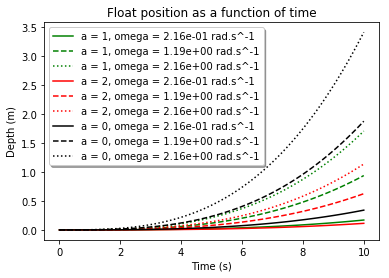

In [40]:
''' Float position as a function of time, depending 
on the added mass (a) and the piston flow u '''

Omega = [12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360.]
A = [1, 1, 1, 2, 2, 2, 0, 0, 0]


t = np.linspace(0,10,100)
fig, ax = plt.subplots()
for o,a in zip(Omega,A):
    params['omega'] = o
    params['u'] = omega2dvdt(params['omega'], params['lead'], params['r_piston'])
    params['a'] = a
    if a == 1:
        color = 'green'
    elif a == 2:
        color = 'red'
    else: # a == 0
        color = 'black'
        
    if 12.4*2.*np.pi/360. - 0.01 <= o <= 12.4*2.*np.pi/360. + 0.01:
        k = 'k'
    elif (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 - 0.01 <= o <= (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 + 0.01:
        k = 'k--'
    else: # 124.*2.*np.pi/360. - 0.01 <= o <= 124.*2.*np.pi/360. + 0.01
        k = 'k:' 
    ax.plot(t, zf(t, params),k, c = color,
            label='a = {}, omega = {:.2e} rad.s^-1'.format(params['a'], o))

plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Float position as a function of time')
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

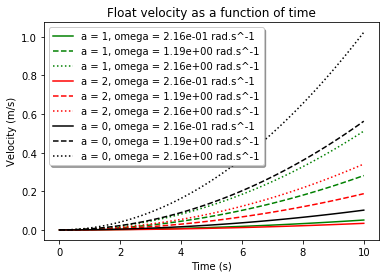

In [41]:
''' Float speed as a function of time, depending
on the added mass (a) and the piston flow u '''

Omega = [12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360.]
A = [1, 1, 1, 2, 2, 2, 0, 0, 0]


t = np.linspace(0,10,100)
fig, ax = plt.subplots()
for o,a in zip(Omega,A):
    params['omega'] = o
    params['u'] = omega2dvdt(params['omega'], params['lead'], params['r_piston'])
    params['a'] = a
    if a == 1:
        color = 'green'
    elif a == 2:
        color = 'red'
    else: # a == 0
        color = 'black'
        
    if 12.4*2.*np.pi/360. - 0.01 <= o <= 12.4*2.*np.pi/360. + 0.01:
        k = 'k'
    elif (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 - 0.01 <= o <= (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 + 0.01:
        k = 'k--'
    else: # 124.*2.*np.pi/360. - 0.01 <= o <= 124.*2.*np.pi/360. + 0.01
        k = 'k:' 
    ax.plot(t, vf(t, params),k, c = color,
            label='a = {}, omega = {:.2e} rad.s^-1'.format(params['a'], o))

plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Float velocity as a function of time')
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

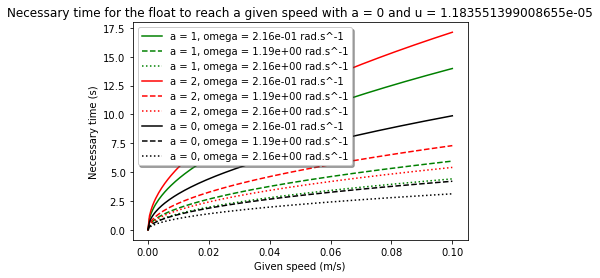

In [42]:
''' Necessary time for the float to reach a given speed '''
v = np.linspace(0, 0.1,200)

Omega = [12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360.]
A = [1, 1, 1, 2, 2, 2, 0, 0, 0]

fig, ax = plt.subplots()
for o,a in zip(Omega,A):
    params['omega'] = o
    params['u'] = omega2dvdt(params['omega'], params['lead'], params['r_piston'])
    params['a'] = a
    if a == 1:
        color = 'green'
    elif a == 2:
        color = 'red'
    else: # a == 0
        color = 'black'
        
    if 12.4*2.*np.pi/360. - 0.01 <= o <= 12.4*2.*np.pi/360. + 0.01:
        k = 'k'
    elif (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 - 0.01 <= o <= (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 + 0.01:
        k = 'k--'
    else: # 124.*2.*np.pi/360. - 0.01 <= o <= 124.*2.*np.pi/360. + 0.01
        k = 'k:' 
    ax.plot(v, tv(v, params),k, c = color,
            label='a = {}, omega = {:.2e} rad.s^-1'.format(params['a'], o))
    plt.xlabel('Given speed (m/s)')
    plt.ylabel('Necessary time (s)')
    plt.title('Necessary time for the float to reach a given speed with a = {} and u = {}'.format(params['a'], params['u']))
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')

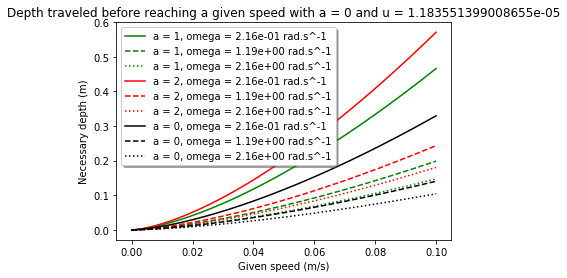

In [43]:
''' Necessary depth for the float to reach a given speed '''
v = np.linspace(0, 0.1,200)

Omega = [12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360., 12.4*2.*np.pi/360., 
         (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2,
         124.*2.*np.pi/360.]
A = [1, 1, 1, 2, 2, 2, 0, 0, 0]

fig, ax = plt.subplots()
for o,a in zip(Omega,A):
    params['omega'] = o
    params['u'] = omega2dvdt(params['omega'], params['lead'], params['r_piston'])
    params['a'] = a
    if a == 1:
        color = 'green'
    elif a == 2:
        color = 'red'
    else: # a == 0
        color = 'black'
        
    if 12.4*2.*np.pi/360. - 0.01 <= o <= 12.4*2.*np.pi/360. + 0.01:
        k = 'k'
    elif (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 - 0.01 <= o <= (12.4*2.*np.pi/360. + 124.*2.*np.pi/360.)/2 + 0.01:
        k = 'k--'
    else: # 124.*2.*np.pi/360. - 0.01 <= o <= 124.*2.*np.pi/360. + 0.01
        k = 'k:' 
    ax.plot(v, zv(v, params),k, c = color,
            label='a = {}, omega = {:.2e} rad.s^-1'.format(params['a'], o))
    plt.xlabel('Given speed (m/s)')
    plt.ylabel('Necessary depth (m)')
    plt.title('Depth traveled before reaching a given speed with a = {} and u = {}'.format(params['a'], params['u']))
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')